# Exploratory Data Analysis

This notebook performs comprehensive exploratory data analysis to understand:
- Data quality and basic statistics
- Temporal patterns in CTR
- Campaign-level characteristics
- Preliminary exposure analysis (prep for Research Question 1)

---

## Prerequisites

**Input Data**: `../data/samples/criteo_fatigue_optimized.csv.gz` (created by `01_data_acquisition.ipynb`)

**Output Data**: `../data/processed/data_with_exposures.csv.gz` (input for `03_feature_engineering.ipynb`)

## Data Pipeline Position

```
01_data_acquisition.ipynb → [02_exploratory_analysis.ipynb] → 03_feature_engineering.ipynb → 04-06 Analysis
```

In [ ]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load sample data (gzipped for smaller repo size)
sample_path = "../data/samples/criteo_fatigue_optimized.csv.gz"
df = pd.read_csv(sample_path, compression='gzip')

print(f"Loaded {len(df):,} records")
print(f"Columns: {len(df.columns)}")
df.head()


Loaded 500,000 records
Columns: 22


,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,-1,138937,9312274,4281154,29196072,28928366,29196072,21857352,29196072,29196072
1,37,15687359,2576437,0,-1,-1,0,1,-1,-1,...,-1,5824233,7477605,8562388,29196072,32440044,1973606,6954913,32440044,29196072
2,97,7327454,28137208,0,-1,-1,0,0,-1,-1,...,-1,30763035,26597095,29562678,29196072,32440047,30763035,12831389,29196072,29196072
3,110,22075924,32368244,0,-1,-1,0,1,-1,-1,...,138,25259032,7477605,8516481,17152695,11409684,1973606,6266944,29841067,22419790
4,141,23042801,32368244,0,-1,-1,0,1,-1,-1,...,-1,138937,7477605,19107905,29196072,11409684,1973606,17502812,32440044,29196072


## Step 1: Basic Data Quality and Statistics


In [2]:
# Identify key columns based on Criteo Attribution Dataset structure
# From README.md: timestamp, uid, campaign, click, conversion, cat1-9, etc.

# Column mappings for Criteo Attribution Dataset:
click_col = 'click'  # Primary target: click (0/1)
# Alternative: use 'conversion' for conversion analysis

user_col = 'uid'  # User identifier (from dataset)
campaign_col = 'campaign'  # Campaign identifier (from dataset)
time_col = 'timestamp'  # Timestamp (from dataset, starting from 0)

# Basic statistics
print("=== Basic Statistics ===")
print(f"Total impressions: {len(df):,}")
if click_col in df.columns:
    print(f"Overall CTR: {df[click_col].mean():.4f} ({df[click_col].sum():,} clicks)")
    print(f"Click distribution:")
    print(df[click_col].value_counts())

print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nMissing values:")
missing = df.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(missing)
else:
    print("No missing values")


=== Basic Statistics ===
Total impressions: 500,000
Overall CTR: 0.3334 (166,716 clicks)
Click distribution:
0    333284
1    166716
Name: click, dtype: int64

Memory usage: 83.92 MB

Missing values:
No missing values


## Step 2: Temporal Patterns


Original timestamp dtype: int64
Timestamp sample (first 5): 0      7
1     37
2     97
3    110
4    141
Name: timestamp, dtype: int64
Timestamp range: 7 to 2671193

Converted timestamp dtype: datetime64[ns]
Converted timestamp range: 2024-01-01 00:00:07 to 2024-01-31 21:59:53

Hour range: 0 to 23
Unique hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
Day names present: ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']

CTR by hour summary:
           CTR  Impressions
hour                       
0     0.348179         4064
1     0.355663         2896
2     0.365994         2776
3     0.375207         3622
4     0.351493         6094
5     0.354923        11101
6     0.350956        17042
7     0.341594        22758
8     0.327515        25953
9     0.325852        26644

CTR by day of week summary:
                CTR  Impressions
day_name                        
Monday     0.327658        80819
Tuesday    0.329273        79806
Wednesday  0.339333        75112
Thursday 

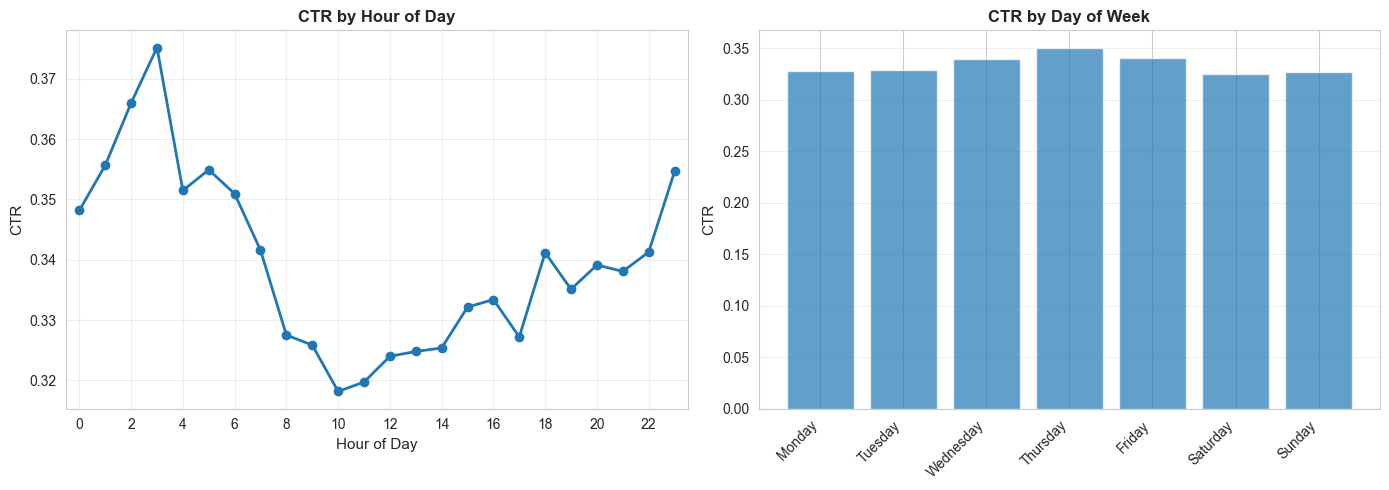


Temporal patterns saved to ../results/figures/temporal_patterns.png


In [3]:
if time_col in df.columns and click_col in df.columns:
    # Parse timestamp (if not already datetime)
    print(f"Original timestamp dtype: {df[time_col].dtype}")
    print(f"Timestamp sample (first 5): {df[time_col].head()}")
    print(f"Timestamp range: {df[time_col].min()} to {df[time_col].max()}")
    
    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        # If timestamp is numeric (seconds since start), convert to datetime
        if df[time_col].dtype in ['int64', 'float64', 'int32', 'float32']:
            # Check if values are very large (might be milliseconds or microseconds)
            max_val = df[time_col].max()
            if max_val > 86400 * 365:  # More than a year in seconds
                # Might be milliseconds
                if max_val > 86400 * 365 * 1000:
                    # Might be microseconds
                    df[time_col] = pd.to_datetime(df[time_col], unit='us')
                else:
                    df[time_col] = pd.to_datetime(df[time_col], unit='ms')
            else:
                # Assume seconds
                reference_date = pd.Timestamp('2024-01-01')
                df[time_col] = pd.to_datetime(reference_date) + pd.to_timedelta(df[time_col], unit='s')
        else:
            df[time_col] = pd.to_datetime(df[time_col])
    
    print(f"\nConverted timestamp dtype: {df[time_col].dtype}")
    print(f"Converted timestamp range: {df[time_col].min()} to {df[time_col].max()}")
    
    # Extract temporal features
    df['hour'] = df[time_col].dt.hour
    df['day_of_week'] = df[time_col].dt.dayofweek
    df['day_name'] = df[time_col].dt.day_name()
    df['month'] = df[time_col].dt.month
    
    print(f"\nHour range: {df['hour'].min()} to {df['hour'].max()}")
    print(f"Unique hours: {sorted(df['hour'].unique())[:10]}...")  # Show first 10
    print(f"Day names present: {df['day_name'].unique()}")
    
    # CTR by hour
    ctr_by_hour = df.groupby('hour')[click_col].agg(['mean', 'count'])
    ctr_by_hour.columns = ['CTR', 'Impressions']
    ctr_by_hour = ctr_by_hour.sort_index()  # Sort by hour
    
    # CTR by day of week
    ctr_by_dow = df.groupby('day_name')[click_col].agg(['mean', 'count'])
    ctr_by_dow.columns = ['CTR', 'Impressions']  # Rename columns first
    # Reindex to ensure all days are present (fill missing with NaN)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ctr_by_dow = ctr_by_dow.reindex(day_order)
    
    print(f"\nCTR by hour summary:")
    print(ctr_by_hour.head(10))
    print(f"\nCTR by day of week summary:")
    print(ctr_by_dow)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Hour plot
    axes[0].plot(ctr_by_hour.index, ctr_by_hour['CTR'], marker='o', linewidth=2, markersize=6)
    axes[0].set_xlabel('Hour of Day', fontsize=11)
    axes[0].set_ylabel('CTR', fontsize=11)
    axes[0].set_title('CTR by Hour of Day', fontsize=12, fontweight='bold')
    axes[0].set_xlim(-0.5, 23.5)  # Set proper x-axis range for hours
    axes[0].set_xticks(range(0, 24, 2))  # Show every 2 hours
    axes[0].grid(True, alpha=0.3)
    
    # Day of week plot
    ctr_by_dow_clean = ctr_by_dow.dropna()
    if len(ctr_by_dow_clean) > 0:
        axes[1].bar(range(len(ctr_by_dow_clean)), ctr_by_dow_clean['CTR'], alpha=0.7)
        axes[1].set_xticks(range(len(ctr_by_dow_clean)))
        axes[1].set_xticklabels(ctr_by_dow_clean.index, rotation=45, ha='right')
        axes[1].set_ylabel('CTR', fontsize=11)
        axes[1].set_title('CTR by Day of Week', fontsize=12, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'No data available', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('CTR by Day of Week', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../results/figures/temporal_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTemporal patterns saved to ../results/figures/temporal_patterns.png")
else:
    print(f"Missing required columns. time_col='{time_col}', click_col='{click_col}'")
    print(f"Available columns: {list(df.columns)}")


## Step 3: Campaign-Level Analysis


Total campaigns: 675

Campaign size distribution:
count      675.000000
mean       740.740741
std       1347.228097
min          1.000000
25%        149.500000
50%        322.000000
75%        753.500000
max      14012.000000
Name: impressions, dtype: float64

Campaign CTR distribution:
count    675.000000
mean       0.319524
std        0.098408
min        0.000000
25%        0.258431
50%        0.314775
75%        0.371690
max        0.691729
Name: ctr, dtype: float64

Top 10 campaigns by impressions:
     campaign  impressions       ctr
640  30801593        14012  0.382244
379  17686799        12054  0.294674
217  10341182        11849  0.409908
329  15398570        10445  0.332791
101   5061834         9519  0.267150
598  29427842         6942  0.306540
326  15184511         6822  0.324978
399  18975823         6349  0.439597
575  28351001         5983  0.588166
10     497593         5831  0.396501

Top 10 campaigns by CTR (min 100 impressions):
     campaign  impressions       ctr


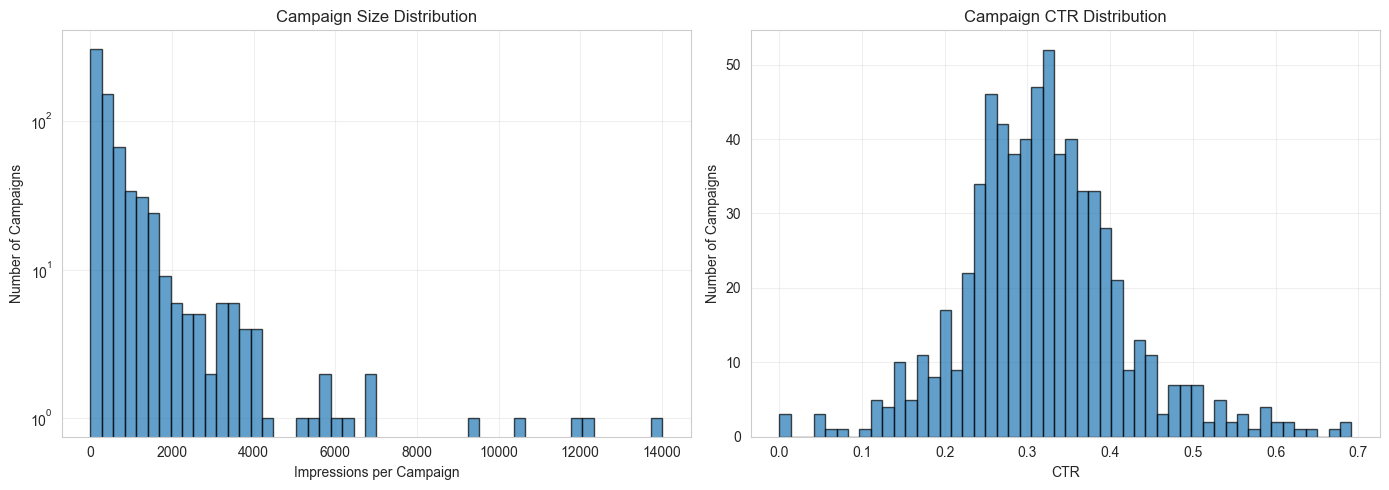

In [4]:
if campaign_col in df.columns and click_col in df.columns:
    # Campaign statistics
    campaign_stats = df.groupby(campaign_col).agg({
        click_col: ['count', 'sum', 'mean']
    }).reset_index()
    campaign_stats.columns = [campaign_col, 'impressions', 'clicks', 'ctr']
    
    print(f"Total campaigns: {campaign_stats[campaign_col].nunique():,}")
    print(f"\nCampaign size distribution:")
    print(campaign_stats['impressions'].describe())
    
    print(f"\nCampaign CTR distribution:")
    print(campaign_stats['ctr'].describe())
    
    # Top campaigns by volume
    print("\nTop 10 campaigns by impressions:")
    print(campaign_stats.nlargest(10, 'impressions')[[campaign_col, 'impressions', 'ctr']])
    
    # Top campaigns by CTR
    print("\nTop 10 campaigns by CTR (min 100 impressions):")
    top_ctr = campaign_stats[campaign_stats['impressions'] >= 100].nlargest(10, 'ctr')
    print(top_ctr[[campaign_col, 'impressions', 'ctr']])
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(campaign_stats['impressions'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Impressions per Campaign')
    axes[0].set_ylabel('Number of Campaigns')
    axes[0].set_title('Campaign Size Distribution')
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(campaign_stats['ctr'], bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('CTR')
    axes[1].set_ylabel('Number of Campaigns')
    axes[1].set_title('Campaign CTR Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/campaign_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


## Step 4: Preliminary Exposure Analysis (Research Question 1 Prep)

This analysis provides an initial look at how CTR changes with exposure count.


Exposure count statistics:
  Max exposure: 196
  Mean exposure: 2.76
  Users with >1 exposure: 176,295
  User-campaign pairs: 323,705

CTR by Exposure Count (min 50 samples per exposure level):
    exposure_count       ctr  impressions  clicks  ctr_lower  ctr_upper
0                1  0.304296       323705   98502   0.302711   0.305881
1                2  0.340523        58648   19971   0.336688   0.344358
2                3  0.353909        31720   11226   0.348647   0.359172
3                4  0.364695        19929    7268   0.358012   0.371378
4                5  0.385026        13664    5261   0.376867   0.393185
5                6  0.395429         9845    3893   0.385771   0.405088
6                7  0.405821         7353    2984   0.394597   0.417045
7                8  0.421375         5717    2409   0.408575   0.434175
8                9  0.428004         4535    1941   0.413604   0.442405
9               10  0.433324         3607    1563   0.417152   0.449496
10            

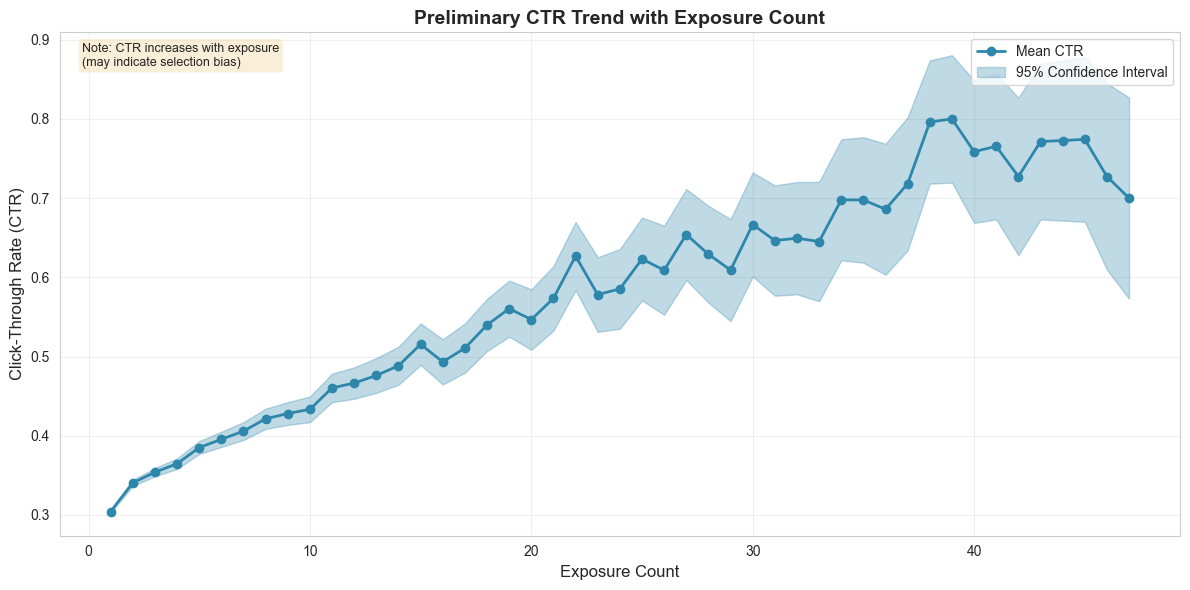


Preliminary decay curve saved to ../results/figures/preliminary_decay.png

Data with exposure counts saved to ../data/processed/data_with_exposures.csv.gz


In [5]:
if all(col in df.columns for col in [user_col, campaign_col, time_col, click_col]):
    # Sort by timestamp
    df_sorted = df.sort_values([user_col, campaign_col, time_col])
    
    # Compute exposure count for each user-campaign pair
    df_sorted['exposure_count'] = (
        df_sorted.groupby([user_col, campaign_col])
        .cumcount() + 1
    )
    
    print(f"Exposure count statistics:")
    print(f"  Max exposure: {df_sorted['exposure_count'].max()}")
    print(f"  Mean exposure: {df_sorted['exposure_count'].mean():.2f}")
    print(f"  Users with >1 exposure: {(df_sorted['exposure_count'] > 1).sum():,}")
    print(f"  User-campaign pairs: {df_sorted.groupby([user_col, campaign_col]).ngroups:,}")
    
    # Compute CTR by exposure count
    ctr_by_exposure = df_sorted.groupby('exposure_count')[click_col].agg([
        ('ctr', 'mean'),
        ('impressions', 'count'),
        ('clicks', 'sum')
    ]).reset_index()
    
    # Calculate confidence intervals (95% CI using normal approximation)
    n = ctr_by_exposure['impressions']
    p = ctr_by_exposure['ctr']
    se = np.sqrt(p * (1 - p) / n)
    z = 1.96  # 95% confidence
    ctr_by_exposure['ctr_lower'] = np.maximum(0, p - z * se)
    ctr_by_exposure['ctr_upper'] = np.minimum(1, p + z * se)
    
    # Filter to exposure counts with sufficient samples (lower threshold to see more data)
    min_samples = 50  # Reduced from 100 to see more exposure levels
    ctr_by_exposure_filtered = ctr_by_exposure[ctr_by_exposure['impressions'] >= min_samples].copy()
    
    print(f"\nCTR by Exposure Count (min {min_samples} samples per exposure level):")
    print(ctr_by_exposure_filtered.head(30))
    print(f"\nTotal exposure levels with sufficient data: {len(ctr_by_exposure_filtered)}")
    
    # Check if CTR is increasing or decreasing
    if len(ctr_by_exposure_filtered) >= 2:
        first_ctr = ctr_by_exposure_filtered.iloc[0]['ctr']
        last_ctr = ctr_by_exposure_filtered.iloc[-1]['ctr']
        change = last_ctr - first_ctr
        change_pct = (change / first_ctr * 100) if first_ctr > 0 else 0
        print(f"\nCTR change from exposure 1 to exposure {ctr_by_exposure_filtered['exposure_count'].max()}:")
        print(f"  Exposure 1 CTR: {first_ctr:.4f}")
        print(f"  Exposure {ctr_by_exposure_filtered['exposure_count'].max()} CTR: {last_ctr:.4f}")
        print(f"  Change: {change:+.4f} ({change_pct:+.2f}%)")
        if change > 0:
            print("  Note: CTR is INCREASING with exposure (opposite of fatigue)")
            print("  This could indicate selection bias or that engaged users see more ads")
        else:
            print("  Note: CTR is DECREASING with exposure (consistent with fatigue)")
    
    # Visualize preliminary decay curve with confidence intervals
    plt.figure(figsize=(12, 6))
    
    # Plot with confidence intervals
    plt.plot(ctr_by_exposure_filtered['exposure_count'], ctr_by_exposure_filtered['ctr'], 
             'o-', linewidth=2, markersize=6, label='Mean CTR', color='#2E86AB')
    plt.fill_between(
        ctr_by_exposure_filtered['exposure_count'],
        ctr_by_exposure_filtered['ctr_lower'],
        ctr_by_exposure_filtered['ctr_upper'],
        alpha=0.3, color='#2E86AB', label='95% Confidence Interval'
    )
    
    plt.xlabel('Exposure Count', fontsize=12)
    plt.ylabel('Click-Through Rate (CTR)', fontsize=12)
    plt.title('Preliminary CTR Trend with Exposure Count', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add annotation if we see increasing trend
    if len(ctr_by_exposure_filtered) >= 2:
        first_ctr = ctr_by_exposure_filtered.iloc[0]['ctr']
        last_ctr = ctr_by_exposure_filtered.iloc[-1]['ctr']
        if last_ctr > first_ctr:
            max_exp = ctr_by_exposure_filtered['exposure_count'].max()
            plt.text(0.02, 0.98, 
                    f'Note: CTR increases with exposure\n(may indicate selection bias)',
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../results/figures/preliminary_decay.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nPreliminary decay curve saved to ../results/figures/preliminary_decay.png")
    
    # Save processed data for next steps
    df_sorted.to_csv('../data/processed/data_with_exposures.csv.gz', index=False, compression='gzip')
    print("\nData with exposure counts saved to ../data/processed/data_with_exposures.csv.gz")
else:
    print("Required columns not found. Please update column names in earlier cells.")
    print(f"Looking for: {[user_col, campaign_col, time_col, click_col]}")
    print(f"Available columns: {list(df.columns)}")
